# Setting up

In [ ]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Layer, Conv2D, Input, BatchNormalization, Add, \
AveragePooling2D, MaxPooling2D, ZeroPadding2D, ReLU, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import datasets, layers, models, optimizers, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import l2

We'll be using CIFAR-10 for this.

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

In [ ]:
# Verify the shape of the dataset
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Train images shape: (50000, 32, 32, 3)
Train labels shape: (50000, 1)
Test images shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)


In [ ]:
print(train_images[0].shape)

(32, 32, 3)


In [ ]:
image_shape = train_images[0].shape


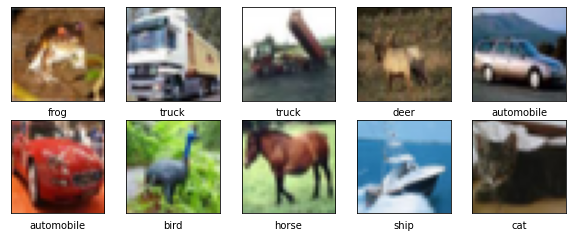

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

# ResNet 50

In [ ]:
def identity_block(X, f, filters, stage, block):

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, 
               kernel_size=(1, 1), 
               strides=(1, 1), 
               padding='valid', 
               name=conv_name_base + '2a', 
               kernel_initializer='glorot_uniform')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = ReLU()(X)

    X = Conv2D(filters=F2, 
               kernel_size=(f, f), 
               strides=(1, 1), 
               padding='same', 
               name=conv_name_base + '2b', 
               kernel_initializer='glorot_uniform')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = ReLU()(X)

    X = Conv2D(filters=F3, 
               kernel_size=(1, 1), 
               strides=(1, 1), 
               padding='valid', 
               name=conv_name_base + '2c', 
               kernel_initializer='glorot_uniform')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])
    X = ReLU()(X)

    return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, stride=2):

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, 
               kernel_size=(1, 1), 
               strides=(stride, stride), 
               padding='valid', 
               name=conv_name_base + '2a', 
               kernel_initializer='glorot_uniform')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = ReLU()(X)

    X = Conv2D(filters=F2, 
               kernel_size=(f, f), 
               strides=(1, 1), 
               padding='same', 
               name=conv_name_base + '2b', kernel_initializer='glorot_uniform')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = ReLU()(X)

    X = Conv2D(filters=F3, 
               kernel_size=(1, 1), 
               strides=(1, 1), 
               padding='valid', 
               name=conv_name_base + '2c', 
               kernel_initializer='glorot_uniform')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, 
                        kernel_size=(1, 1), 
                        strides=(stride, stride), 
                        padding='valid', name=conv_name_base + '1', 
                        kernel_initializer='glorot_uniform')(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = ReLU()(X)

    return X


In [ ]:
def ResNet50(input_shape=(224, 224, 3), output_shape=1):

    inputs = Input(input_shape, name='input')

    X = ZeroPadding2D((3, 3))(inputs)

    X = Conv2D(filters=64, 
               kernel_size=(7, 7), 
               strides=(2, 2), 
               name='conv1', 
               kernel_initializer='glorot_uniform')(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = ReLU()(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', stride=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', stride=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', stride=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', stride=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    X = Flatten()(X)
    X = Dense(256, activation='relu', name='fc1', kernel_initializer='glorot_uniform')(X)
    X = Dense(128, activation='relu', name='fc2', kernel_initializer='glorot_uniform')(X)


              
    assert output_shape>=1
    if output_shape==1:
        outputs = Dense(output_shape, activation='sigmoid')(X)
    else:
        outputs = Dense(output_shape, activation='softmax')(X)
    model = Model(inputs=inputs, outputs=outputs, name='ResNet50')

    return model

In [ ]:
model = ResNet50(input_shape=image_shape, output_shape=10)

In [ ]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)   0           ['input[0][0]']                  
                                                                                                  
 conv1 (Conv2D)                 (None, 16, 16, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1[0][0]']                  
                                                                                           

In [ ]:
# If the val loss did not decrease in 3 times, model will stop training and restore best weights
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_rn50 = model.fit(train_images, train_labels, epochs=10, 
                    validation_split=0.2,
                    callbacks=[early_stopping])

Epoch 1/10
1250/1250 [==============================] - 113s 49ms/step - loss: 1.7727 - accuracy: 0.3550 - val_loss: 1.6509 - val_accuracy: 0.4176
Epoch 2/10
1250/1250 [==============================] - 61s 48ms/step - loss: 1.5306 - accuracy: 0.4467 - val_loss: 1.7455 - val_accuracy: 0.3905
Epoch 3/10
1250/1250 [==============================] - 59s 47ms/step - loss: 1.4449 - accuracy: 0.4813 - val_loss: 1.6870 - val_accuracy: 0.3636
Epoch 4/10
1250/1250 [==============================] - 60s 48ms/step - loss: 1.4327 - accuracy: 0.4895 - val_loss: 1.4517 - val_accuracy: 0.4758
Epoch 5/10
1250/1250 [==============================] - 59s 47ms/step - loss: 1.3684 - accuracy: 0.5137 - val_loss: 1.6243 - val_accuracy: 0.4285
Epoch 6/10
1250/1250 [==============================] - 61s 49ms/step - loss: 1.2619 - accuracy: 0.5578 - val_loss: 1.5486 - val_accuracy: 0.4735
Epoch 7/10
1250/1250 [==============================] - 58s 46ms/step - loss: 1.1541 - accuracy: 0.5991 - val_loss: 1.4979 

In [ ]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

313/313 - 4s - loss: 1.4437 - accuracy: 0.4803 - 4s/epoch - 14ms/step


# ResNet50 (Overfit)

In [ ]:
def identity_block(X, f, filters, stage, block):

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, 
               kernel_size=(1, 1), 
               strides=(1, 1), 
               padding='valid', 
               name=conv_name_base + '2a', 
               kernel_initializer='glorot_uniform')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = ReLU()(X)

    X = Conv2D(filters=F2, 
               kernel_size=(f, f), 
               strides=(1, 1), 
               padding='same', 
               name=conv_name_base + '2b', 
               kernel_initializer='glorot_uniform')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = ReLU()(X)

    X = Conv2D(filters=F3, 
               kernel_size=(1, 1), 
               strides=(1, 1), 
               padding='valid', 
               name=conv_name_base + '2c', 
               kernel_initializer='glorot_uniform')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])
    X = ReLU()(X)

    return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, stride=2):

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, 
               kernel_size=(1, 1), 
               strides=(stride, stride), 
               padding='valid', 
               name=conv_name_base + '2a', 
               kernel_initializer='glorot_uniform')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = ReLU()(X)


    X = Conv2D(filters=F2, 
               kernel_size=(f, f), 
               strides=(1, 1), 
               padding='same', 
               name=conv_name_base + '2b', kernel_initializer='glorot_uniform')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = ReLU()(X)

    X = Conv2D(filters=F3, 
               kernel_size=(1, 1), 
               strides=(1, 1), 
               padding='valid', 
               name=conv_name_base + '2c', 
               kernel_initializer='glorot_uniform')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, 
                        kernel_size=(1, 1), 
                        strides=(stride, stride), 
                        padding='valid', name=conv_name_base + '1', 
                        kernel_initializer='glorot_uniform')(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = ReLU()(X)

    return X


In [ ]:
def ResNet50(input_shape=(224, 224, 3), output_shape=1):

    inputs = Input(input_shape, name='input')

    X = ZeroPadding2D((3, 3))(inputs)

    X = Conv2D(filters=64, 
               kernel_size=(7, 7), 
               strides=(2, 2), 
               name='conv1', 
               kernel_initializer='glorot_uniform')(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = ReLU()(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', stride=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', stride=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')


    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', stride=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')


    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', stride=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')


    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    X = Flatten()(X)
    #X = Dense(256, activation='relu', name='fc1', kernel_initializer='glorot_uniform')(X)
    #X = Dense(128, activation='relu', name='fc2', kernel_initializer='glorot_uniform')(X)

    X = Dense(256, activation='relu', name='fc1', kernel_initializer='glorot_uniform'\
              , kernel_regularizer=regularizers.l2(0.01))(X)
    X = Dense(128, activation='relu', name='fc2', kernel_initializer='glorot_uniform'\
              , kernel_regularizer=regularizers.l2(0.01))(X)

    assert output_shape>=1
    if output_shape==1:
        outputs = Dense(output_shape, activation='sigmoid')(X)
    else:
        outputs = Dense(output_shape, activation='softmax')(X)
    model = Model(inputs=inputs, outputs=outputs, name='ResNet50')

    return model

In [ ]:
model = ResNet50(input_shape=image_shape, output_shape=10)

In [ ]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, 38, 38, 3)   0           ['input[0][0]']                  
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 16, 16, 64)   9472        ['zero_padding2d_1[0][0]']       
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1[0][0]']           

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_rn50of = model.fit(train_images, train_labels, epochs=10, 
                    validation_split=0.2,
                    callbacks=[early_stopping])

Epoch 1/10
1250/1250 [==============================] - 93s 48ms/step - loss: 2.4547 - accuracy: 0.3479 - val_loss: 1.7397 - val_accuracy: 0.3875
Epoch 2/10
1250/1250 [==============================] - 60s 48ms/step - loss: 1.5350 - accuracy: 0.4651 - val_loss: 1.5692 - val_accuracy: 0.4458
Epoch 3/10
1250/1250 [==============================] - 58s 47ms/step - loss: 1.3515 - accuracy: 0.5392 - val_loss: 1.8468 - val_accuracy: 0.4227
Epoch 4/10
1250/1250 [==============================] - 60s 48ms/step - loss: 1.2067 - accuracy: 0.6022 - val_loss: 1.3539 - val_accuracy: 0.5380
Epoch 5/10
1250/1250 [==============================] - 58s 47ms/step - loss: 1.0994 - accuracy: 0.6393 - val_loss: 1.2683 - val_accuracy: 0.5806
Epoch 6/10
1250/1250 [==============================] - 59s 47ms/step - loss: 1.0026 - accuracy: 0.6752 - val_loss: 1.2035 - val_accuracy: 0.6121
Epoch 7/10
1250/1250 [==============================] - 61s 49ms/step - loss: 0.9034 - accuracy: 0.7103 - val_loss: 1.0365 -

In [ ]:

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

313/313 - 3s - loss: 1.0525 - accuracy: 0.6567 - 3s/epoch - 10ms/step


# ResNet 50 (Vanishing)

In [ ]:
def identity_block(X, f, filters, stage, block):

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, 
               kernel_size=(1, 1), 
               strides=(1, 1), 
               padding='valid', 
               name=conv_name_base + '2a', 
               kernel_initializer='glorot_uniform')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = ReLU()(X)

    X = Conv2D(filters=F2, 
               kernel_size=(f, f), 
               strides=(1, 1), 
               padding='same', 
               name=conv_name_base + '2b', 
               kernel_initializer='glorot_uniform')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = ReLU()(X)

    X = Conv2D(filters=F3, 
               kernel_size=(1, 1), 
               strides=(1, 1), 
               padding='valid', 
               name=conv_name_base + '2c', 
               kernel_initializer='glorot_uniform')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])
    X = ReLU()(X)

    return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, stride=2):

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, 
               kernel_size=(1, 1), 
               strides=(stride, stride), 
               padding='valid', 
               name=conv_name_base + '2a', 
               kernel_initializer='glorot_uniform')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = ReLU()(X)

    X = Conv2D(filters=F2, 
               kernel_size=(f, f), 
               strides=(1, 1), 
               padding='same', 
               name=conv_name_base + '2b', kernel_initializer='glorot_uniform')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = ReLU()(X)

    X = Conv2D(filters=F3, 
               kernel_size=(1, 1), 
               strides=(1, 1), 
               padding='valid', 
               name=conv_name_base + '2c', 
               kernel_initializer='glorot_uniform')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, 
                        kernel_size=(1, 1), 
                        strides=(stride, stride), 
                        padding='valid', name=conv_name_base + '1', 
                        kernel_initializer='glorot_uniform')(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = ReLU()(X)

    return X


In [ ]:
def ResNet50(input_shape=(224, 224, 3), output_shape=1):

    inputs = Input(input_shape, name='input')

    X = ZeroPadding2D((3, 3))(inputs)

    X = Conv2D(filters=64, 
               kernel_size=(7, 7), 
               strides=(2, 2), 
               name='conv1', 
               kernel_initializer='glorot_uniform')(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = ReLU()(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # add batch normalization after ReLU activation
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', stride=1)
    X = BatchNormalization(axis=3, name='bn_conv2')(X) 
    X = ReLU()(X)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = BatchNormalization(axis=3, name='bn_conv3')(X) 
    X = ReLU()(X)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    X = BatchNormalization(axis=3, name='bn_conv4')(X)
    X = ReLU()(X)

    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', stride=2)
    X = BatchNormalization(axis=3, name='bn_conv5')(X)
    X = ReLU()(X)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = BatchNormalization(axis=3, name='bn_conv6')(X) 
    X = ReLU()(X)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = BatchNormalization(axis=3, name='bn_conv7')(X)
    X = ReLU()(X)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')


    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', stride=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')


    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', stride=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')


    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    X = Flatten()(X)
    X = Dense(256, activation='relu', name='fc1', kernel_initializer='glorot_uniform')(X)
    X = Dense(128, activation='relu', name='fc2', kernel_initializer='glorot_uniform')(X)



    assert output_shape>=1
    if output_shape==1:
        outputs = Dense(output_shape, activation='sigmoid')(X)
    else:
        outputs = Dense(output_shape, activation='softmax')(X)
    model = Model(inputs=inputs, outputs=outputs, name='ResNet50')

    return model

In [ ]:
model = ResNet50(input_shape=image_shape, output_shape=10)

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 38, 38, 3)   0           ['input[0][0]']                  
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 16, 16, 64)   9472        ['zero_padding2d_2[0][0]']       
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1[0][0]']           

In [ ]:
history_rn50v = model.fit(train_images, train_labels, epochs=10, 
                    validation_split=0.2,
                    callbacks=[early_stopping])

Epoch 1/10
1250/1250 [==============================] - 99s 51ms/step - loss: 1.8996 - accuracy: 0.2968 - val_loss: 1.8616 - val_accuracy: 0.3412
Epoch 2/10
1250/1250 [==============================] - 63s 50ms/step - loss: 1.6436 - accuracy: 0.3958 - val_loss: 1.8958 - val_accuracy: 0.2977
Epoch 3/10
1250/1250 [==============================] - 63s 50ms/step - loss: 1.5317 - accuracy: 0.4446 - val_loss: 1.7798 - val_accuracy: 0.3970
Epoch 4/10
1250/1250 [==============================] - 64s 51ms/step - loss: 1.3950 - accuracy: 0.4988 - val_loss: 1.6220 - val_accuracy: 0.3969
Epoch 5/10
1250/1250 [==============================] - 61s 49ms/step - loss: 1.4106 - accuracy: 0.4925 - val_loss: 1.5726 - val_accuracy: 0.4134
Epoch 6/10
1250/1250 [==============================] - 60s 48ms/step - loss: 1.4130 - accuracy: 0.4933 - val_loss: 1.8493 - val_accuracy: 0.3728
Epoch 7/10
1250/1250 [==============================] - 61s 49ms/step - loss: 1.3239 - accuracy: 0.5256 - val_loss: 1.6085 -

In [ ]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

313/313 - 3s - loss: 1.1043 - accuracy: 0.6187 - 3s/epoch - 11ms/step


# CNN

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from keras import regularizers

model = models.Sequential(
[ 

    layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)),
    layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),

    layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),

    layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),

    layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
 
    layers.Dense(10, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 128)       1

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    patience=3,
    restore_best_weights=True    
)
variable_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor = 0.2, 
    patience = 2
)

In [ ]:
opt = optimizers.SGD(learning_rate=0.01, momentum=0.9)

In [ ]:
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
history_cnn = model.fit(train_images, train_labels, epochs=20, 
                    validation_split=0.1,
                    callbacks=[early_stopping]
                    )

Epoch 1/20
1407/1407 [==============================] - 78s 53ms/step - loss: 1.6728 - accuracy: 0.4079 - val_loss: 2.5218 - val_accuracy: 0.2654
Epoch 2/20
1407/1407 [==============================] - 74s 53ms/step - loss: 1.1441 - accuracy: 0.6031 - val_loss: 2.5562 - val_accuracy: 0.3378
Epoch 3/20
1407/1407 [==============================] - 74s 53ms/step - loss: 0.9093 - accuracy: 0.6893 - val_loss: 1.4819 - val_accuracy: 0.5086
Epoch 4/20
1407/1407 [==============================] - 74s 53ms/step - loss: 0.7296 - accuracy: 0.7516 - val_loss: 1.4502 - val_accuracy: 0.5558
Epoch 5/20
1407/1407 [==============================] - 74s 53ms/step - loss: 0.5325 - accuracy: 0.8224 - val_loss: 1.4640 - val_accuracy: 0.5828
Epoch 6/20
1407/1407 [==============================] - 74s 53ms/step - loss: 0.3321 - accuracy: 0.8947 - val_loss: 1.7479 - val_accuracy: 0.5508
Epoch 7/20
1407/1407 [==============================] - 74s 52ms/step - loss: 0.1859 - accuracy: 0.9458 - val_loss: 4.2533 -

# CNN (Overfit)

In [ ]:
from keras import regularizers

model = models.Sequential(
[ 

    layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)),
    layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),

    layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),

    layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),

    layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(16, activation='relu'),
    layers.BatchNormalization(),

    layers.Dense(10, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_34 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_22 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_35 (Conv2D)          (None, 16, 16, 64)       

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    patience=3,
    restore_best_weights=True    
)
variable_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor = 0.2, 
    patience = 2
)

In [ ]:
opt = optimizers.SGD(learning_rate=0.01, momentum=0.9)

In [ ]:
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
history_cnnof = model.fit(train_images, train_labels, epochs=16, 
                    validation_split=0.1,
                    callbacks=[early_stopping]
                    )

Epoch 1/16
1407/1407 [==============================] - 31s 20ms/step - loss: 2.0256 - accuracy: 0.2585 - val_loss: 2.0065 - val_accuracy: 0.2976
Epoch 2/16
1407/1407 [==============================] - 18s 13ms/step - loss: 1.6666 - accuracy: 0.3798 - val_loss: 1.6724 - val_accuracy: 0.4016
Epoch 3/16
1407/1407 [==============================] - 19s 13ms/step - loss: 1.5138 - accuracy: 0.4463 - val_loss: 1.4821 - val_accuracy: 0.4616
Epoch 4/16
1407/1407 [==============================] - 19s 13ms/step - loss: 1.3820 - accuracy: 0.5027 - val_loss: 1.6191 - val_accuracy: 0.4202
Epoch 5/16
1407/1407 [==============================] - 19s 14ms/step - loss: 1.2686 - accuracy: 0.5499 - val_loss: 1.4911 - val_accuracy: 0.4954
Epoch 6/16
1407/1407 [==============================] - 20s 14ms/step - loss: 1.1787 - accuracy: 0.5837 - val_loss: 1.2660 - val_accuracy: 0.5626
Epoch 7/16
1407/1407 [==============================] - 19s 14ms/step - loss: 1.1040 - accuracy: 0.6135 - val_loss: 1.3206 -

# CNN (Vanishing)

In [ ]:
from keras import regularizers

model = models.Sequential(
[ 
    layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
        

    layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
        

    layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),
        

    layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(16, activation='relu'),
    layers.BatchNormalization(),

    layers.Dense(10, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_8 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_23 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_9 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                      

In [ ]:
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
history_cnnv = model.fit(train_images, train_labels, epochs=20, 
                    validation_data=(test_images, test_labels))

Epoch 1/20
1563/1563 [==============================] - 28s 15ms/step - loss: 2.0504 - accuracy: 0.2220 - val_loss: 1.7347 - val_accuracy: 0.3491
Epoch 2/20
1563/1563 [==============================] - 24s 15ms/step - loss: 1.7635 - accuracy: 0.3219 - val_loss: 1.6018 - val_accuracy: 0.4074
Epoch 3/20
1563/1563 [==============================] - 25s 16ms/step - loss: 1.6109 - accuracy: 0.3933 - val_loss: 1.4485 - val_accuracy: 0.4592
Epoch 4/20
1563/1563 [==============================] - 23s 15ms/step - loss: 1.4828 - accuracy: 0.4570 - val_loss: 1.3774 - val_accuracy: 0.4961
Epoch 5/20
1563/1563 [==============================] - 24s 15ms/step - loss: 1.3589 - accuracy: 0.5119 - val_loss: 1.3114 - val_accuracy: 0.5288
Epoch 6/20
1563/1563 [==============================] - 23s 15ms/step - loss: 1.2718 - accuracy: 0.5489 - val_loss: 1.2054 - val_accuracy: 0.5645
Epoch 7/20
1563/1563 [==============================] - 24s 16ms/step - loss: 1.2006 - accuracy: 0.5783 - val_loss: 1.0900 -

# Eval

## ResNet50

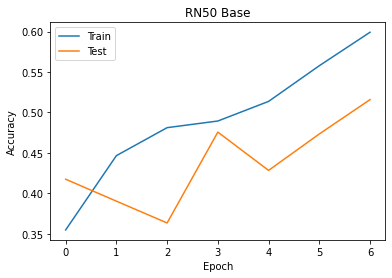

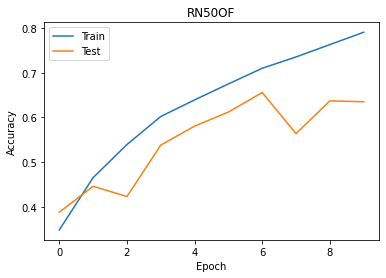

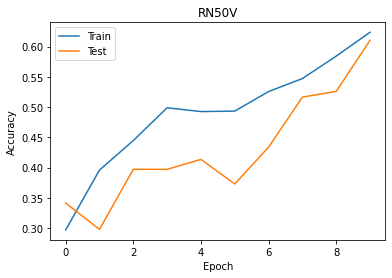

In [ ]:

plt.plot(history_rn50.history['accuracy'])
plt.plot(history_rn50.history['val_accuracy'])
plt.title('RN50 Base')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_rn50of.history['accuracy'])
plt.plot(history_rn50of.history['val_accuracy'])
plt.title('RN50OF')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_rn50v.history['accuracy'])
plt.plot(history_rn50v.history['val_accuracy'])
plt.title('RN50V')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## CNN

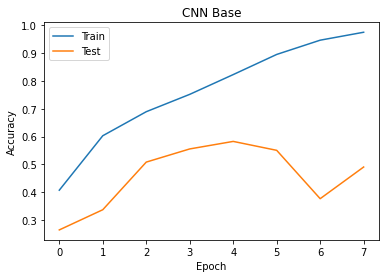

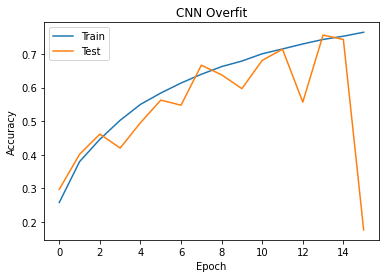

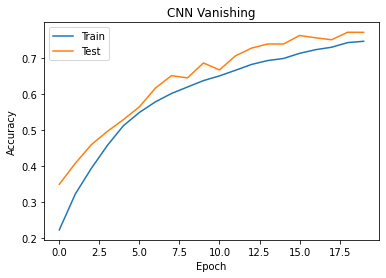

In [ ]:

plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('CNN Base')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_cnnof.history['accuracy'])
plt.plot(history_cnnof.history['val_accuracy'])
plt.title('CNN Overfit')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_cnnv.history['accuracy'])
plt.plot(history_cnnv.history['val_accuracy'])
plt.title('CNN Vanishing')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Eval 2

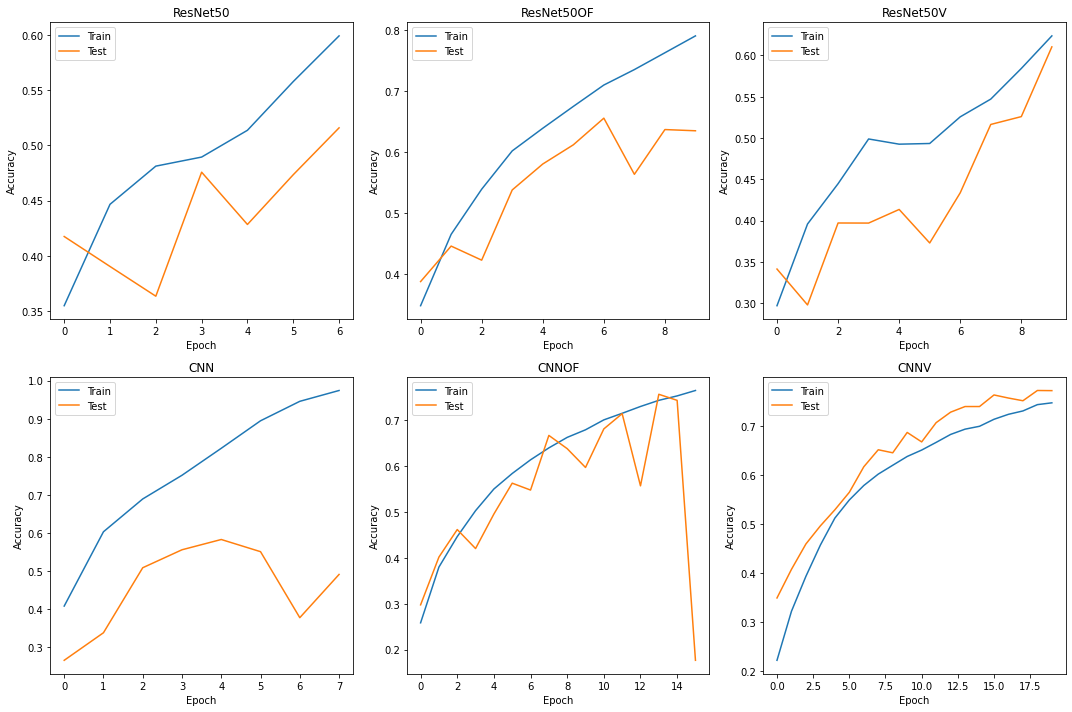

In [ ]:
# Create a new figure with six subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,10))

# Plot the training and validation accuracy for each model on a subplot
axs[0,0].plot(history_rn50.history['accuracy'])
axs[0,0].plot(history_rn50.history['val_accuracy'])
axs[0,0].set_title('ResNet50')
axs[0,0].set_xlabel('Epoch')
axs[0,0].set_ylabel('Accuracy')
axs[0,0].legend(['Train', 'Test'], loc='upper left')

axs[0,1].plot(history_rn50of.history['accuracy'])
axs[0,1].plot(history_rn50of.history['val_accuracy'])
axs[0,1].set_title('ResNet50OF')
axs[0,1].set_xlabel('Epoch')
axs[0,1].set_ylabel('Accuracy')
axs[0,1].legend(['Train', 'Test'], loc='upper left')

axs[0,2].plot(history_rn50v.history['accuracy'])
axs[0,2].plot(history_rn50v.history['val_accuracy'])
axs[0,2].set_title('ResNet50V')
axs[0,2].set_xlabel('Epoch')
axs[0,2].set_ylabel('Accuracy')
axs[0,2].legend(['Train', 'Test'], loc='upper left')

axs[1,0].plot(history_cnn.history['accuracy'])
axs[1,0].plot(history_cnn.history['val_accuracy'])
axs[1,0].set_title('CNN')
axs[1,0].set_xlabel('Epoch')
axs[1,0].set_ylabel('Accuracy')
axs[1,0].legend(['Train', 'Test'], loc='upper left')

axs[1,1].plot(history_cnnof.history['accuracy'])
axs[1,1].plot(history_cnnof.history['val_accuracy'])
axs[1,1].set_title('CNNOF')
axs[1,1].set_xlabel('Epoch')
axs[1,1].set_ylabel('Accuracy')
axs[1,1].legend(['Train', 'Test'], loc='upper left')

axs[1,2].plot(history_cnnv.history['accuracy'])
axs[1,2].plot(history_cnnv.history['val_accuracy'])
axs[1,2].set_title('CNNV')
axs[1,2].set_xlabel('Epoch')
axs[1,2].set_ylabel('Accuracy')
axs[1,2].legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()
